<center><h3> Next step to performing non-linear regression...uncertainty estimation! </h3></center>


---

<center><h2>Error Ellipse Tool<h2></center>
<center><h4>Visualizing and quantifying confidence intervals of coupled parameters</h4></center>
    
----

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.lines as lines
import plotly.graph_objects as go
import plotly
import plotly.express as px
import math
from scipy.misc import derivative
import ipywidgets as widgets
from ipywidgets import interact, Button
import autograd.numpy as np
from autograd import elementwise_grad

#### Set font sizes

In [2]:
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
d={0.76:10,1.002:20,1.1932:30,1.5382:50,1.811:68,2.154:80,2.79:95, 3.3682:99}
c={0.76:'b',1.002:'m',1.1932:'g',1.5382:'k',1.811:'b',2.154:'w',2.79:'r', 3.3682:'k'}

<div align="center">Defining a parabolic function $y(x_1,x_2,x_3)$</div>


<div align="center"><b>$ y=ax_{1}^2 + bx_2 + bx_1 x_3^2 + noise$</b></div>

#### Generate data

    🔈 Enter normally start and stop values to generate random normally distributed data 

In [25]:
x1_start, x1_stop = -10, 10
x2_start, x2_stop = -5, 5
x3_start, x3_stop = 0, 20

num_data_pts = 100

start_noise, stop_noise = 0, 100

In [26]:
x1 = np.random.normal(x1_start, x1_stop,num_data_pts ) 
x2 = np.random.normal(x2_start, x2_stop,num_data_pts )
x3 = np.random.normal(x3_start, x3_stop,num_data_pts )

X = np.column_stack([x1, x2, x3]) # stacking independent variables
noise = np.random.normal(start_noise, stop_noise, num_data_pts)

In [27]:
# Enter function with combinations of x1, x2, x3 and add noise
# The three terms here have some parameters: a=5, b = 13, c =0.1

y = 5*x1**2 + 13*x2 + 0.1*x1*x3**2 + noise

#### Define model

    🔈 Here, unpack the independent variables and define the model

In [28]:
def model(X,a,b,c):
    x1 = X[:,0]
    x2 = X[:,1]
    x3 = X[:,2]
    return a*x1**2 + b*x2 + c*x1*x3**2

#### Fitting data

    🔈 Fitting the data x1, x2, x3 to the model to find the parameters using "curve_fit"

In [29]:
pars,pcov = curve_fit(model, X, y)
# print(f'The fitted parameter values are \n \n a={pars[0]:1.3f}, b={pars[1]:1.3f}, c={pars[2]:1.3f}')
# print(f'\n \nThe covariance matrix is \n \n{pcov}')

#### Define loss function

    🔈 Now that we know the optimal parameters and covariance matrix, let's plot contours of the sum of squared errors. For this, we will have to define the error function and also wrapper functions which takes in arguments in different order

In [30]:
@np.vectorize
def errfunc(a,b,c):
    fit = model(X,a,b,c)
    return np.sum((fit-y)**2)

def proxy1(b,c,a):
    return errfunc(a,b,c)

def proxy2(a,c,b):
    return errfunc(a,b,c)

#### Range for parameters

     🔈 Setting the parameter ranges about the optimum value and creating a meshgrid for contour plots

In [41]:
arange = np.linspace(pars[0]-5*np.sqrt(pcov[0,0]),pars[0]+5*np.sqrt(pcov[0,0]),101)
brange = np.linspace(pars[1]-5*np.sqrt(pcov[1,1]),pars[1]+5*np.sqrt(pcov[1,1]),101)
crange = np.linspace(pars[2]-5*np.sqrt(pcov[2,2]),pars[2]+5*np.sqrt(pcov[2,2]),101)

A,B = np.meshgrid(arange,brange)
B_,C_ = np.meshgrid(brange,crange)
AA,CC = np.meshgrid(arange,crange)

SSE1 = errfunc(A,B,pars[2])
SSE2 = proxy1(B_,C_,pars[0])
SSE3 = proxy2(AA,CC,pars[1])

#### Sorting eigen values with highest values first


    🔈 Diagonalizing the covariance matrix and sorting the eigen values and vectors in ascending order

In [32]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


#### Finding Taylor approximation corresponding to the confidence interval

In [44]:
def change1(conf):
    global ellip1
    proj_mat = np.linalg.inv((float(conf.new)**2)*(pcov))
    new_mat =np.abs([[proj_mat[0,0],proj_mat[0,1]],[proj_mat[1,0],proj_mat[1,1]]] )
    vals,vecs = eigsorted(new_mat)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2/( np.sqrt(np.abs(vals)))
    ellip1 = Ellipse(xy=(pars[0],pars[1]), width=width, height=height, angle=-theta,facecolor='none',edgecolor=c[conf.new],linestyle='-.')
    ax1.add_artist(ellip1)

    # Get the path
    path = ellip1.get_path()
    # Get the list of path vertices
    vertices = path.vertices.copy()
    # Transform the vertices so that they have the correct coordinates
    vertices = ellip1.get_patch_transform().transform(vertices)
    vert_x = vertices[:,0]
    vert_y = vertices[:,1]
#     ax1.plot(vert_x,vert_y,'*')

    def f(a,b):
        return errfunc(a,b,pars[2])
    def prox(b,a):
        return f(a,b)
    f_ab=f(pars[0],pars[1])
    m = vert_x[0]
    n = vert_y[0]

    def Fxx(a,y):
        return derivative(f,a,dx=1e-6,args=(y,)) # Value of y in args

    def Fyy(b,x):
        return derivative(prox,b,dx=1e-6,args=(x,)) # Value of x in args

    def Fxy(x,y):
        return derivative(prox,y,dx=1e-6,args=(x,))

    x_val, y_val = pars[0],pars[1]
    fxx=derivative(Fxx,x_val,dx=1e-6,args=(y_val,)) # Value of x in arg
    fyy=derivative(Fyy,y_val,dx=1e-6,args=(x_val,)) # Value of y in arg
    fxy=derivative(Fxy,x_val,dx=1e-6,args=(y_val,)) # Value of x in main and y in arg

    y_ideal_1 = f_ab + 0.5*((m - pars[0])**2*fxx + 2*(m - pars[0])*(n-pars[1])*fxy + (n-pars[1])**2*fyy)
    plot1=ax1.contour(A,B,SSE1,levels=[y_ideal_1],alpha=0.5,colors='black')
    ax1.clabel(plot1,inline=True,colors='black')

#### Plotting contours

<IPython.core.display.Javascript object>


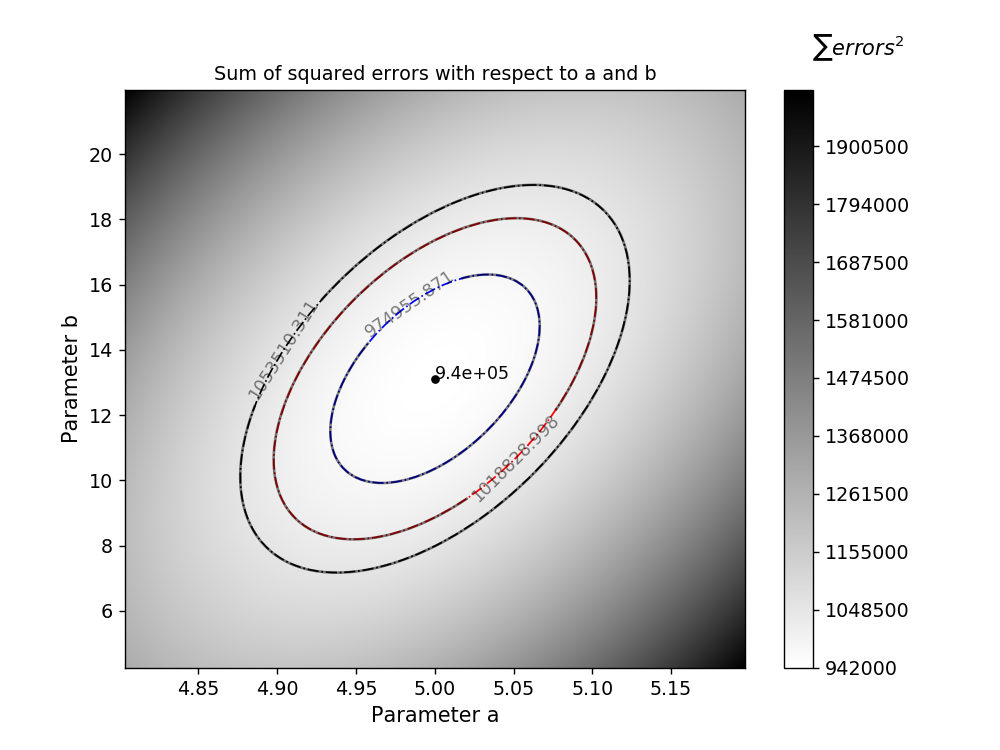

SelectionSlider(continuous_update=False, description='% CI', index=4, options=(('10', 0.76), ('20', 1.002), ('…

In [45]:
%matplotlib notebook
%matplotlib notebook


fig1,ax1 = plt.subplots(figsize=(8,6))
plot1= ax1.contourf(A,B,SSE1,1000,alpha=1,cmap='gist_yarg')
ax1.set_xlabel('Parameter a')
ax1.set_ylabel('Parameter b')
ax1.set_title('Sum of squared errors with respect to a and b')
cb1=fig1.colorbar(plot1)
cb1.set_label(r'$\sum {errors}^2$',rotation=0,labelpad=-30, y=1.1)

fig1.show()

ax1.plot(pars[0],pars[1],'k.',markersize=8)
ax1.annotate(f'{errfunc(pars[0],pars[1],pars[2]):1.2}',xy=(pars[0],pars[1]),color='black')


int_slider = widgets.SelectionSlider(
    options=[ ('10',0.76),('20',1.002),('30',1.1932),('50',1.5382),('68',1.811),('80',2.154),('95',2.79),('99',3.3682)],
    value=1.811,
    description='% CI',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
int_slider.observe(change1, names='value')
int_slider.style.handle_color = 'yellow'
int_slider
display(int_slider)
